In [1]:
import jetnet
from jetnet.datasets import JetNet
import numpy as np
import matplotlib.pyplot as plt
import gen_metrics
from tqdm import tqdm
import pandas as pd
from IPython.display import Markdown, display
import pickle
import plotting
from typing import OrderedDict

plt.rcParams.update({"font.size": 16})


In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import os

plot_dir = "../plots/jet_plots/Nov10"
_ = os.system(f"mkdir -p {plot_dir}")

data_dir = "../saved_data/"


## Distributions

In [5]:
truth_jets_pf, _ = JetNet.getData(
    "g",
    data_dir="/Users/raghav/Documents/CERN/gen-models/MPGAN/datasets/",
    split_fraction=[1.0, 0, 0],
    particle_features=["etarel", "phirel", "ptrel"],
    jet_features=["pt", "eta", "mass", "num_particles"],
)


In [6]:
# efps = jetnet.utils.efps(truth_jets_pf[:, :, :3], efpset_args=[("d<=", 4)])
# np.save("efps", efps)


In [7]:
efps_true = np.load(f"{data_dir}/efps_true.npy")
pnet_activations_true = np.load(f"{data_dir}/pnet_activations_true.npy")


In [8]:
from coffea.lookup_tools.dense_lookup import dense_lookup

mass = jetnet.utils.jet_features(truth_jets_pf[:, :, :3])["mass"]

np.random.seed(4)

bins = np.linspace(0, np.max(mass), 26)
true_mass_hist = np.histogram(mass, bins)[0]

smeared_hist = np.histogram(mass * np.random.normal(1, 0.25, size=mass.shape), bins)[0]
shifted_hist = np.histogram(mass * np.random.normal(1.1, 0.05, size=mass.shape), bins)[0]

smeared_lookup = dense_lookup(smeared_hist / true_mass_hist, bins)
shifted_lookup = dense_lookup(shifted_hist / true_mass_hist, bins)

smeared_weights = smeared_lookup(mass)
smeared_weights /= np.sum(smeared_weights)

shifted_weights = shifted_lookup(mass)
shifted_weights /= np.sum(shifted_weights)

tailcut_weights = (mass < 0.17).astype(float)
tailcut_weights /= np.sum(tailcut_weights)

dists = OrderedDict(
    [
        ("truth", (np.ones(truth_jets_pf.shape[0]) / truth_jets_pf.shape[0], "Truth")),
        ("smeared", (smeared_weights, "Smeared")),
        ("shifted", (shifted_weights, "Shifted")),
        ("tailcut", (tailcut_weights, "Removing Tail")),
    ]
)


In [9]:
# np.random.seed(4)

# pf_dists = OrderedDict()

# pf_dists["all_smeared"] = (
#     truth_jets_pf * np.random.normal(1, 0.25, size=truth_jets_pf.shape),
#     "Particle Features Smeared",
# )
# pf_dists["eta_smeared"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., 0:1] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 0:1].shape),
#             truth_jets_pf[..., 1:],
#         ),
#         axis=-1,
#     ),
#     r"Particle $\eta^{rel}$ Smeared",
# )
# pf_dists["pt_smeared"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., :2],
#             truth_jets_pf[..., 2:3] * np.random.normal(1, 0.25, size=truth_jets_pf[..., 2:3].shape),
#         ),
#         axis=-1,
#     ),
#     r"Particle $p_T^{rel}$ Smeared",
# )
# pf_dists["pt_shifted"] = (
#     np.concatenate(
#         (
#             truth_jets_pf[..., :2],
#             truth_jets_pf[..., 2:3]
#             * np.random.normal(0.9, 0.1, size=truth_jets_pf[..., 2:3].shape),
#         ),
#         axis=-1,
#     ),
#     r"Particle $p_T^{rel}$ Shifted",
# )


In [10]:
# with open("pf_dists.pkl", "wb") as f:
#     pickle.dump(pf_dists, f)


In [11]:
# efps = {
#     key: jetnet.utils.efps(jets, efpset_args=[("d<=", 4)]) for key, (jets, _) in pf_dists.items()
# }
#
# with open("efps_dict.pkl", "wb") as f:
#     pickle.dump(efps, f)


In [12]:
with open(f"{data_dir}/pf_dists.pkl", "rb") as f:
    pf_dists = pickle.load(f)

with open(f"{data_dir}/efps_dict.pkl", "rb") as f:
    efps = pickle.load(f)

pnet_activations = {}

for key in pf_dists:
    pnet_activations[key] = np.load(f"{data_dir}/pnet_activations_{key}.npy")

masses = {key: jetnet.utils.jet_features(jets)["mass"] for key, (jets, _) in pf_dists.items()}


## Plot Distributions

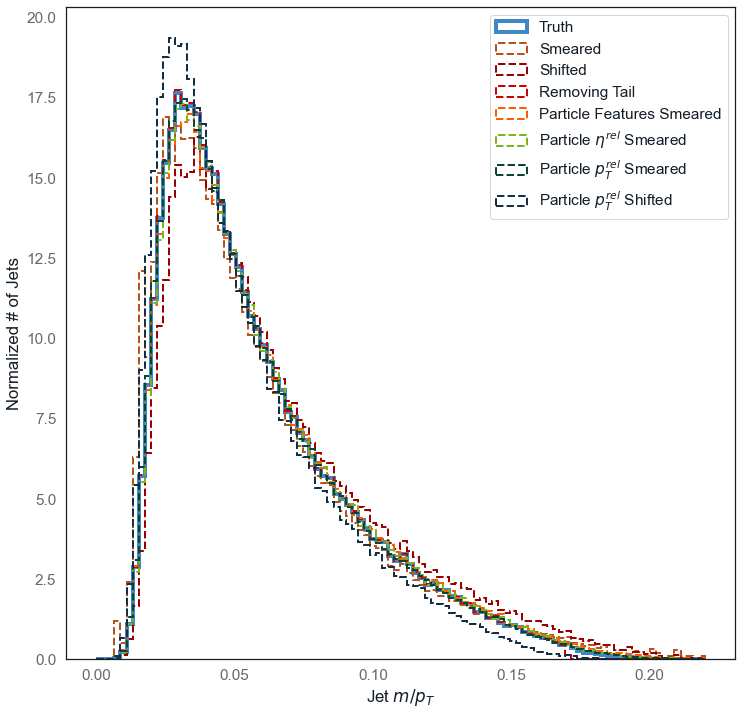

In [13]:
import seaborn as sns


sns.set(
    font_scale=1.4,
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "#141E27",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "#141E27",
        # "axes.spines.right": False,
        # "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "#141E27",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

plt.figure(figsize=(12, 12))

bins = np.linspace(0, 0.22, 101)
colours = ["#3F88C5", "#B3541E", "#990000", "#D00000", "#FF5B00", "#7CB518", "#064635", "#142F43"]

_ = plt.hist(
    mass, bins, histtype="step", label="Truth", linewidth=4, density=True, color=colours[0]
)

i = 1
for weights, label in dists.values():
    if label == "Truth":
        continue

    _ = plt.hist(
        mass,
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
        color=colours[i],
    )

    i += 1

for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        masses[key],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
        color=colours[i],
    )

    i += 1

plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists.pdf", bbox_inches="tight")


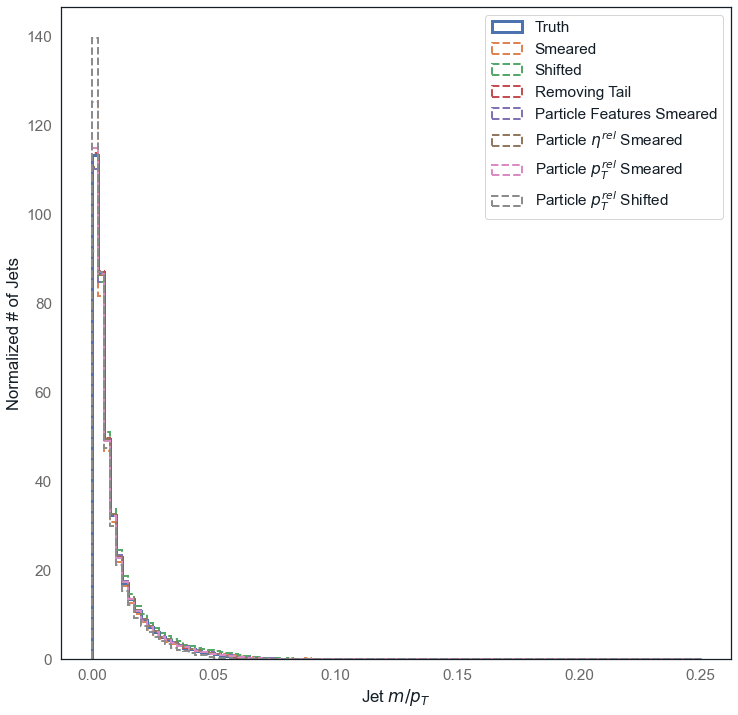

In [14]:
plt.figure(figsize=(12, 12))

# bins = np.linspace(0, 0.04, 101)
bins = np.linspace(0, 0.25, 101)
efp_index = 2

_ = plt.hist(
    efps_true[:, efp_index], bins, histtype="step", label="Truth", linewidth=3, density=True
)
for weights, label in dists.values():
    if label == "Truth":
        continue

    _ = plt.hist(
        efps_true[:, efp_index],
        bins,
        weights=weights,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
for key, (_, label) in pf_dists.items():
    _ = plt.hist(
        efps[key][:, efp_index],
        bins,
        histtype="step",
        label=label,
        linewidth=2,
        linestyle="dashed",
        density=True,
    )
plt.legend()
plt.xlabel(r"Jet $m/p_T$")
plt.ylabel("Normalized # of Jets")
plt.savefig(f"{plot_dir}/jet_dists_efp.pdf", bbox_inches="tight")


## Measurements

In [15]:
num_samples = 150_000
sample_efps = OrderedDict()
sample_acts = OrderedDict()
sample_masses = OrderedDict()

np.random.seed(4)
true_inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
true_mass = mass[true_inds]
true_efps = efps_true[true_inds]
true_acts = pnet_activations_true[true_inds]

for key, (weights, _) in dists.items():
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples, p=weights)
    sample_masses[key] = mass[inds]
    sample_efps[key] = efps_true[inds]
    sample_acts[key] = pnet_activations_true[inds]
    # np.save(f"../distorted_jets/{key}.npy", truth_jets_pf[inds])

for key in pf_dists:
    inds = np.random.choice(np.arange(truth_jets_pf.shape[0]), num_samples)
    sample_masses[key] = masses[key][inds]
    sample_efps[key] = efps[key][inds]
    sample_acts[key] = pnet_activations[key][inds]
    # np.save(f"../distorted_jets/{key}.npy", pf_dists[key][0])


In [16]:
# with open(f"{data_dir}/sample_efps.pkl", 'wb') as f:
#     pickle.dump(sample_efps, f)

In [21]:
num_batches = 5

batch_sizes = {
    "w1m": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
    ],
    "wasserstein": [100, 200, 300, 500, 750, 1000, 1500, 2000],
    "fgd": [
        100,
        200,
        300,
        500,
        750,
        1000,
        1500,
        2000,
        3000,
        5000,
        7500,
        10000,
        15000,
        20000,
        25000,
        30000,
        40000,
        50000,
    ],
    "fgd_inf": [10_000, 15_000, 20_000, 25_000, 30_000, 40_000, 50_000],
    "mmdup4": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000],
    "pr": [100, 200, 300, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000],
}

metrics = OrderedDict(
    [
        ("wasserstein", (gen_metrics.wasserstein, {"normalise": False}, "Wasserstein")),
        ("fgd", (gen_metrics.frechet_gaussian_distance, {}, "Fréchet Gaussian Distance")),
        ("fgd_inf", (gen_metrics.frechet_gaussian_distance, {}, r"$\mathrm{FGD}_{\infty}$")),
        (
            "mmdup4",
            (
                gen_metrics.mmd_poly_quadratic_unbiased,
                {"degree": 4},
                "MMD",
            ),
        ),
        ("pr", (gen_metrics.pr, {}, ["Precision", "Recall"])),
    ]
)


In [18]:
measurements_dir = "../plots/jet_plots/Nov5"

with open(f"{measurements_dir}/measurements_w1m.pkl", "rb") as f:
    measurements_w1m = pickle.load(f)

with open(f"{measurements_dir}/measurements_efps.pkl", "rb") as f:
    measurements_efps = pickle.load(f)

with open(f"{measurements_dir}/measurements_acts.pkl", "rb") as f:
    measurements_acts = pickle.load(f)

### W1m

In [ ]:
measurements_w1m = OrderedDict()
mkey = "w1m"

for dkey in sample_masses:
    ms = []
    ts = []
    for batch_size in tqdm(batch_sizes[mkey], desc=mkey):
        mean_std, timing = gen_metrics.multi_batch_evaluation(
            true_mass,
            sample_masses[dkey],
            num_batches,
            batch_size,
            gen_metrics.wasserstein1d,
            timing=True,
        )
        ms.append(mean_std)
        ts.append(timing)
    measurements_w1m[dkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


### EFPs

In [22]:
if "measurements_efps" not in locals():
    measurements_efps = OrderedDict()

for dkey in sample_efps:
    print(dkey)
    if dkey not in measurements_efps:
        measurements_efps[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (mkey in measurements_efps[dkey] or mkey == "fgd_inf") and not mkey == "mmdup4":
            continue

        ms = []
        ts = []

        # ms = list(measurements_efps[dkey][mkey]["mean_std"])
        # ts = list(measurements_efps[dkey][mkey]["timing"])

        for batch_size in tqdm(batch_sizes[mkey][len(ms):], desc=mkey):
            # mean_std, timing = gen_metrics.multi_batch_evaluation(
            #     true_efps,
            #     sample_efps[dkey],
            #     num_batches,
            #     batch_size,
            #     metric,
            #     timing=True,
            #     **metric_args
            # )
            # ms.append(mean_std)
            # ts.append(timing)

            mean_std = gen_metrics.multi_batch_evaluation_mmd(
                true_efps,
                sample_efps[dkey],
                num_batches,
                batch_size,
            )
            ms.append(mean_std)
            ts.append(0)

        measurements_efps[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


mmdup4: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


smeared


mmdup4: 100%|██████████| 11/11 [00:13<00:00,  1.27s/it]


shifted


mmdup4: 100%|██████████| 11/11 [00:15<00:00,  1.44s/it]


tailcut


mmdup4: 100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


all_smeared


mmdup4: 100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


eta_smeared


mmdup4: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


pt_smeared


mmdup4: 100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


pt_shifted


mmdup4: 100%|██████████| 11/11 [00:17<00:00,  1.58s/it]


#### FGD Infinity

In [ ]:
mkey = "fgd_inf"

for dkey in sample_efps:
    ms = []
    for n in tqdm(batch_sizes[mkey], desc=dkey):
        ms.append(gen_metrics.one_over_n_extrapolation_repeated_measurements(true_efps, sample_efps[dkey], gen_metrics.frechet_gaussian_distance, normalise=True, max_samples=n))

    measurements_efps[dkey][mkey] = {"mean_std": np.array(ms)}
    

### ParticleNet Activations

In [29]:
if "measurements_acts" not in locals():
    measurements_acts = OrderedDict()

for dkey in sample_acts:
    print(dkey)
    if dkey not in measurements_acts:
        measurements_acts[dkey] = OrderedDict()

    for mkey, (metric, metric_args, label) in metrics.items():
        if (mkey in measurements_acts[dkey] or mkey == "fgd_inf") and not mkey == "mmdup4":
            continue

        ms = []
        ts = []

        # ms = list(measurements_acts[dkey][mkey]["mean_std"])[:-2]
        # ts = list(measurements_acts[dkey][mkey]["timing"])[:-2]

        for batch_size in tqdm(batch_sizes[mkey][len(ms):], desc=mkey):
            # mean_std, timing = gen_metrics.multi_batch_evaluation(
            #     true_acts,
            #     sample_acts[dkey],
            #     num_batches,
            #     batch_size,
            #     metric,
            #     timing=True,
            #     **metric_args,
            #     normalise=False
            # )
            # ms.append(mean_std)
            # ts.append(timing)

            mean_std = gen_metrics.multi_batch_evaluation_mmd(
                true_acts,
                sample_acts[dkey],
                num_batches,
                batch_size,
                normalise=False,
            )
            ms.append(mean_std)
            ts.append(0)

        measurements_acts[dkey][mkey] = {"mean_std": np.array(ms), "timing": np.array(ts)}


truth


mmdup4: 100%|██████████| 11/11 [00:11<00:00,  1.09s/it]


smeared


mmdup4: 100%|██████████| 11/11 [00:13<00:00,  1.20s/it]


shifted


mmdup4: 100%|██████████| 11/11 [00:12<00:00,  1.13s/it]


tailcut


mmdup4: 100%|██████████| 11/11 [00:13<00:00,  1.25s/it]


all_smeared


mmdup4: 100%|██████████| 11/11 [00:13<00:00,  1.23s/it]


eta_smeared


mmdup4: 100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


pt_smeared


mmdup4: 100%|██████████| 11/11 [00:14<00:00,  1.28s/it]


pt_shifted


mmdup4: 100%|██████████| 11/11 [00:14<00:00,  1.30s/it]


#### FGD Infinity

In [ ]:
mkey = "fgd_inf"

for dkey in sample_acts:
    ms = []
    for n in tqdm(batch_sizes[mkey], desc=dkey):
        ms.append(gen_metrics.one_over_n_extrapolation_repeated_measurements(true_acts, sample_acts[dkey], normalise=True, max_samples=n, num_points=15))

    measurements_acts[dkey][mkey] = {"mean_std": np.array(ms)}
    

In [23]:
with open(f"{plot_dir}/measurements_w1m.pkl", "wb") as f:
    pickle.dump(measurements_w1m, f)

with open(f"{plot_dir}/measurements_efps.pkl", "wb") as f:
    pickle.dump(measurements_efps, f)

with open(f"{plot_dir}/measurements_acts.pkl", "wb") as f:
    pickle.dump(measurements_acts, f)


## Plot Measurements

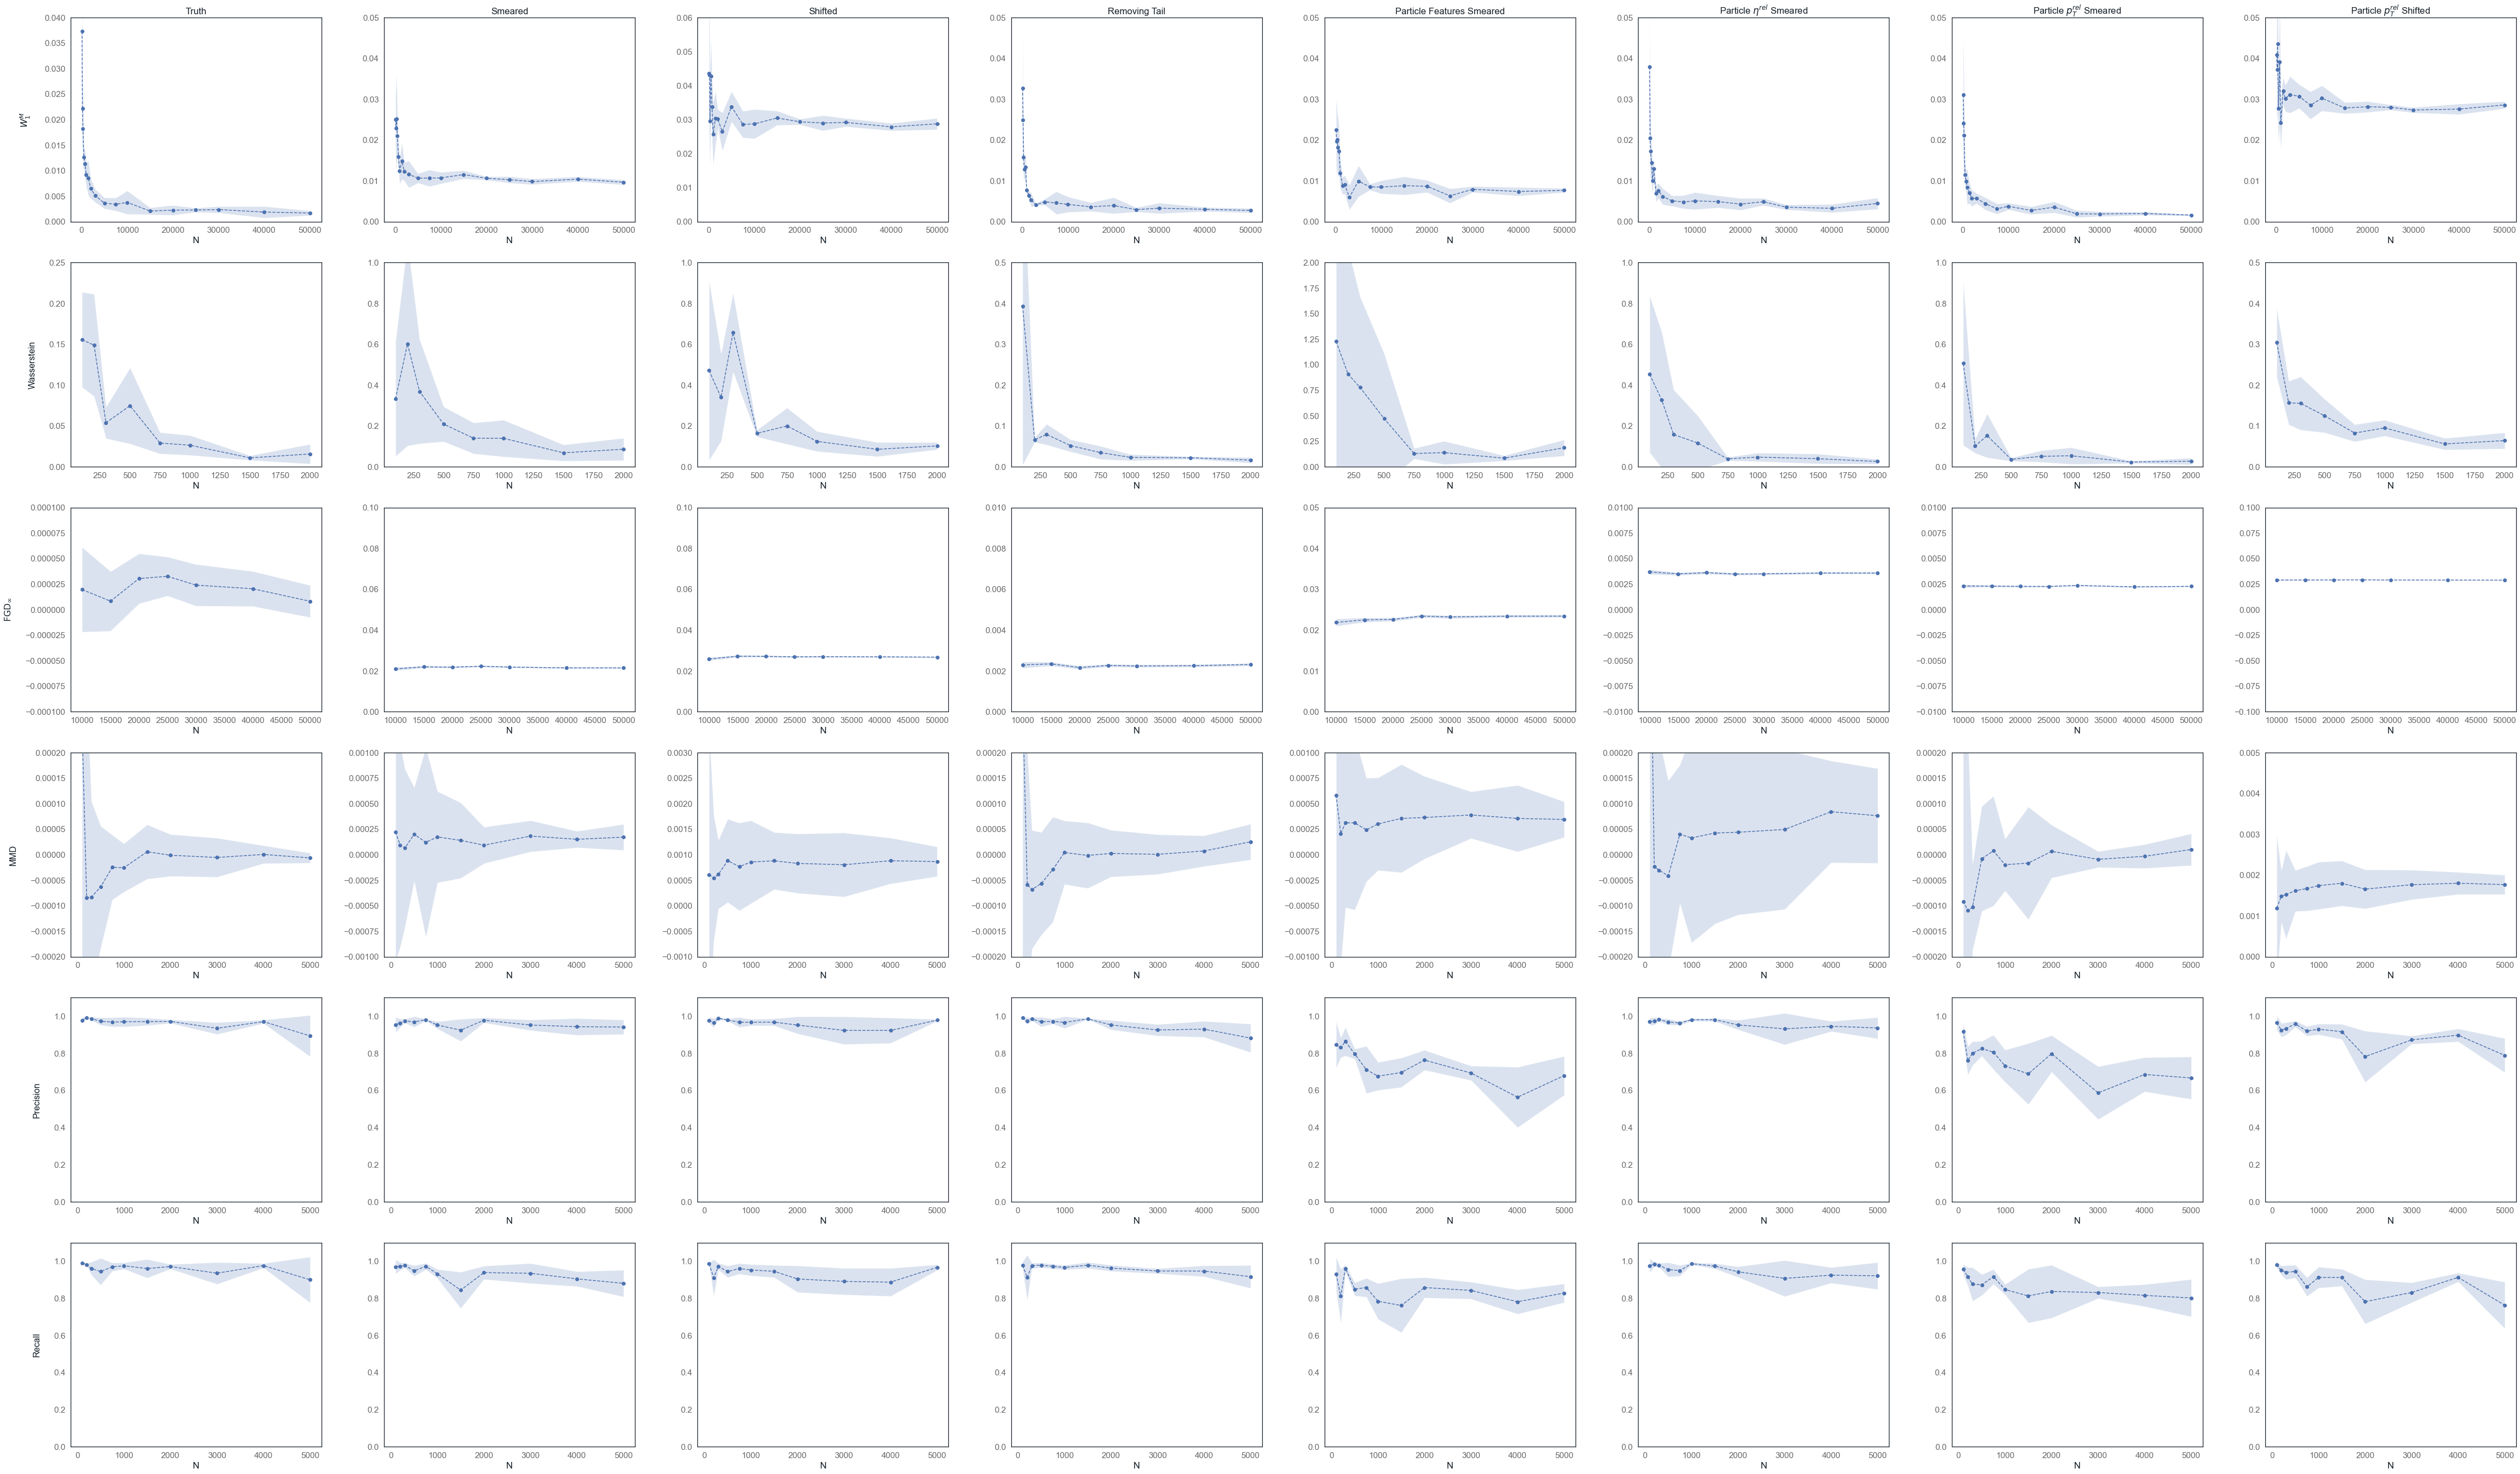

In [24]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("w1m", ([0, 0.04], [0, 0.05], [0, 0.06], [0, 0.05], [0, 0.05], [0, 0.05], [0, 0.05], [0, 0.05])),
        ("wasserstein", ([0, 0.25], [0, 1], [0, 1], [0, 0.5], [0, 2], [0, 1], [0, 1], [0, 0.5])),
        # (
        #     "fgd",
        #     ([0, 0.25], [0, 0.5], [0, 1], [0, 0.1], [0, 0.25], [0, 0.25], [0, 0.15], [0, 0.25]),
        # ),
        (
            "fgd_inf",
            ([-0.0001, 0.0001], [0, 0.1], [0, 0.1], [0, 0.01], [0, 0.05], [-0.01, 0.01], [-0.01, 0.01], [-0.1, 0.1]),
        ),
        (
            "mmdup4",
            (
                [-0.0002, 0.0002],
                [-0.001, 0.001],
                [-0.001, 0.003],
                [-0.0002, 0.0002],
                [-0.001, 0.001],
                [-0.0002, 0.0002],
                [-0.0002, 0.0002],
                [0, 0.005],
            ),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

i = 0
mkey = "w1m"
plotting.metric_label(axes[i][0], r"$W_1^M$")
for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
    axes[i][j].set_title(label)
    plotting.plot_means_stds(
        axes[i][j], measurements_w1m[dkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
    )

for (mkey, (metric, metric_args, label)) in metrics.items():
    if mkey in ["dc", "pr"] or mkey not in ylims:
        continue

    i = list(ylims.keys()).index(mkey)

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        plotting.plot_means_stds(
            axes[i][j], measurements_efps[dkey][mkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, dkey in enumerate(dists | pf_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements_efps[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )


plt.savefig(f"{plot_dir}/efps_scores.pdf", bbox_inches="tight")


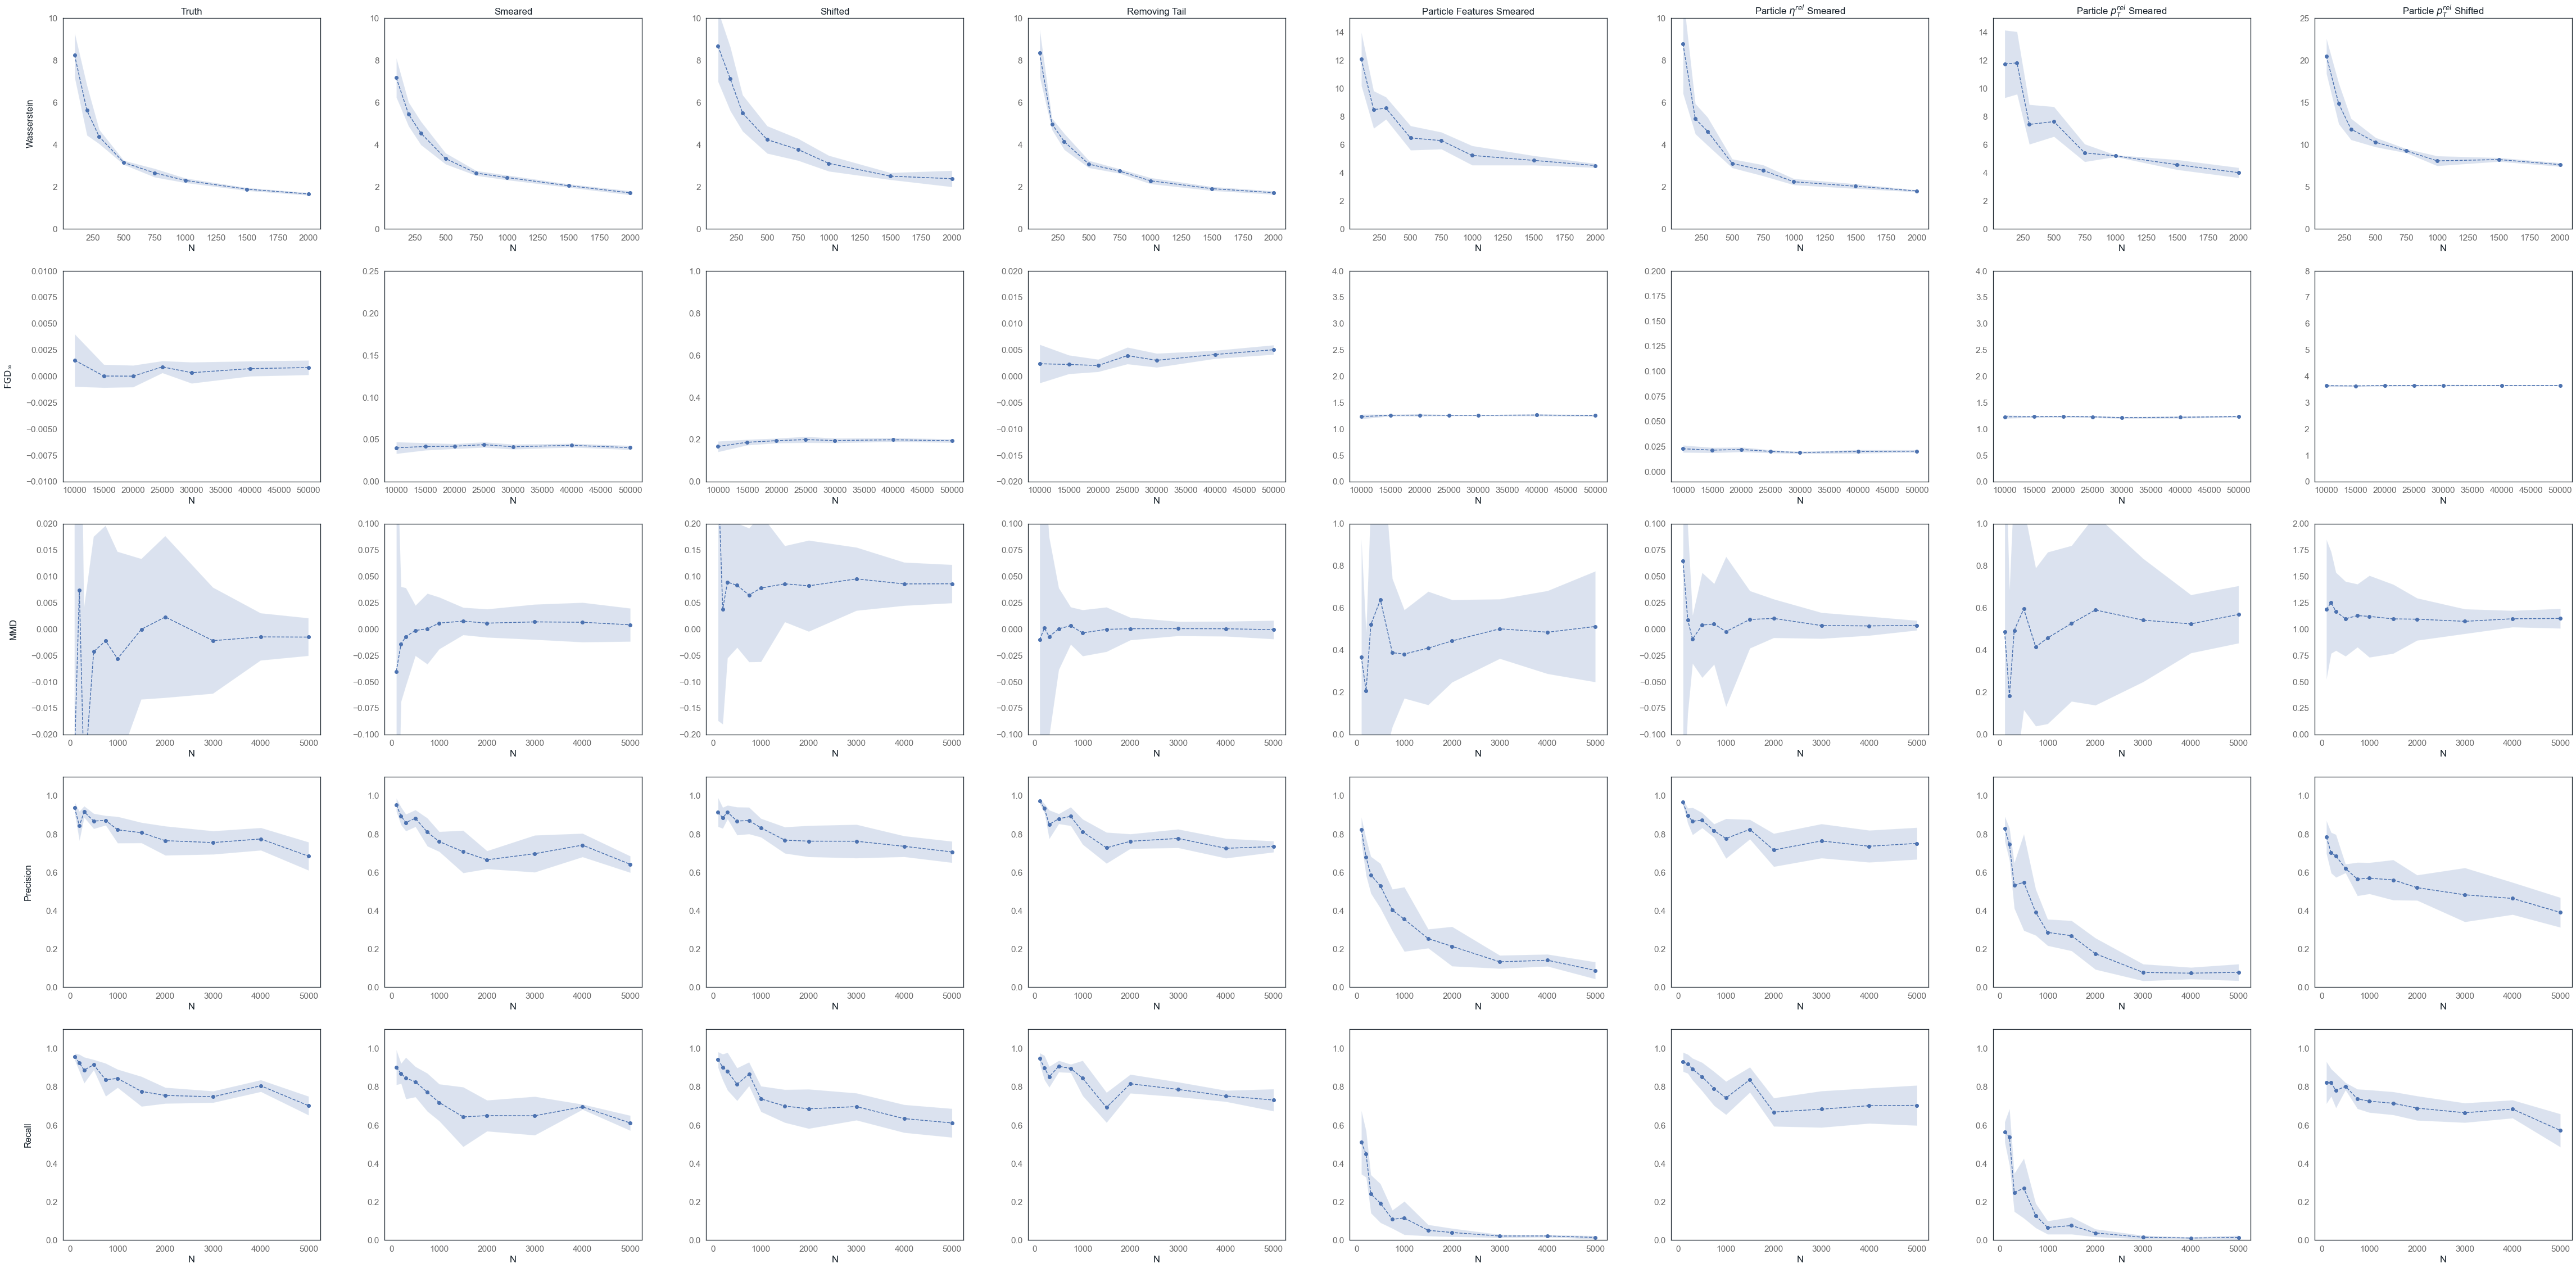

In [30]:
plt.rcParams.update({"font.size": 16})

ylims = OrderedDict(
    [
        ("wasserstein", ([0, 10], [0, 10], [0, 10], [0, 10], [0, 15], [0, 10], [0, 15], [0, 25])),
        # ("fgd", ([0, 2], [0, 2], [0, 2], [0, 2], [0, 5], [0, 2], [0, 8], [0, 10])),
        (
            "fgd_inf",
            ([-0.01, 0.01], [0, 0.25], [0, 1], [-0.02, 0.02], [0, 4], [-0.01, 0.2], [0, 4], [0, 8]),
        ),
        (
            "mmdup4",
            (
                [-0.02, 0.02],
                [-0.1, 0.1],
                [-0.2, 0.2],
                [-0.1, 0.1],
                [0, 1],
                [-0.1, 0.1],
                [0, 1],
                [0, 2],
            ),
        ),
        (
            "precision",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
        (
            "recall",
            ([0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1], [0, 1.1]),
        ),
    ]
)

fig, axes = plt.subplots(
    nrows=len(ylims),
    ncols=len(dists | pf_dists),
    figsize=(len(dists | pf_dists) * 10, len(ylims) * 8),
    gridspec_kw={"wspace": 0.25},
)

for (mkey, (metric, metric_args, label)) in metrics.items():
    if mkey in ["dc", "pr"] or mkey not in ylims:
        continue

    i = list(ylims.keys()).index(mkey)

    plotting.metric_label(axes[i][0], label)
    for j, (dkey, (_, label)) in enumerate((dists | pf_dists).items()):
        if i == 0:
            axes[i][j].set_title(label)

        plotting.plot_means_stds(
            axes[i][j], measurements_acts[dkey][mkey]["mean_std"], batch_sizes[mkey], ylims[mkey][j]
        )

for k, key in enumerate(["precision", "recall"]):
    i = len(ylims) - 2 + k
    mkey = "pr"

    plotting.metric_label(axes[i][0], metrics[mkey][2][k])
    for j, dkey in enumerate(dists | pf_dists):
        plotting.plot_means_stds(
            axes[i][j],
            measurements_acts[dkey][mkey]["mean_std"][:, :, k],
            batch_sizes[mkey],
            ylims[key][j],
        )

plt.savefig(f"{plot_dir}/acts_scores.pdf", bbox_inches="tight")


# Table of values

In [25]:
def format_mean_std(mean_stds: np.ndarray):
    mean, sd = mean_stds

    if sd == 0:
        return f"${mean:.1f} \\pm 0.0$"

    """round mean and standard deviation to most significant digit of sd and apply latex formatting"""
    decimals = -int(np.floor(np.log10(sd)))
    decimals -= int((sd * 10**decimals) >= 9.5)

    if decimals < 0:
        ten_to = 10 ** (-decimals)
        if mean > ten_to:
            mean = ten_to * (mean // ten_to)
        else:
            mean_ten_to = 10 ** np.floor(np.log10(mean))
            mean = mean_ten_to * (mean // mean_ten_to)
        sd = ten_to * (sd // ten_to)
        decimals = 0

    if mean >= 1e3 and sd >= 1e3:
        mean = np.round(mean * 1e-3)
        sd = np.round(sd * 1e-3)
        return f"${mean:.{decimals}f}$k $\\pm {sd:.{decimals}f}$k"
    else:
        return f"${mean:.{decimals}f} \\pm {sd:.{decimals}f}$"


In [31]:
def print_mean_std(mean_stds: np.ndarray):
    return f"{mean_stds[0]:.3f} ± {mean_stds[1]:.3f}"

rows = []
sigs = []  # keeping track of significances

row = [r"$W_1^M \times 10^3$"]
sig = []
true_mean, true_std = measurements_w1m["truth"]["mean_std"][-1]
for dkey, values in measurements_w1m.items():
    row.append(format_mean_std(values['mean_std'][-1, :] * 1e3))
    sig.append((values['mean_std'][-1, 0] - true_mean) / true_std)

rows.append(row)
sigs.append(sig)


for mkey, (metric, metric_args, label) in metrics.items():
    if mkey == "fgd":
        continue

    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " EFP"]
            sig = []

            true_mean, true_std = measurements_efps["truth"][mkey]['mean_std'][-1, :, i]
            for dkey, values in measurements_efps.items():
                row.append(format_mean_std(values[mkey]['mean_std'][-1, :, i]))
                sig.append((values[mkey]['mean_std'][-1, 0, i] - true_mean) / true_std)

            rows.append(row)
            sigs.append(sig)
        # continue
    else:
        sig = []
        true_mean, true_std = measurements_efps["truth"][mkey]['mean_std'][-1]
        
        if mkey in ["fgd_inf", "mmdup4"]:
            row = [f"{label} EFP $\\times 10^3$"]

            for dkey, values in measurements_efps.items():
                row.append(format_mean_std(values[mkey]['mean_std'][-1, :] * 1e3))
                sig.append((values[mkey]['mean_std'][-1, 0] - true_mean) / true_std)

        else:
            row = [label + " EFP"]

            for dkey, values in measurements_efps.items():
                row.append(format_mean_std(values[mkey]['mean_std'][-1, :]))
                sig.append((values[mkey]['mean_std'][-1, 0] - true_mean) / true_std)

        rows.append(row)
        sigs.append(sig)

for mkey, (metric, metric_args, label) in metrics.items():
    if mkey == "fgd":
        continue
    
    if isinstance(label, list):
        for i, l in enumerate(label):
            row = [l + " PN"]
            sig = []

            true_mean, true_std = measurements_acts["truth"][mkey]['mean_std'][-1, :, i]

            for dkey, values in measurements_acts.items():
                row.append(format_mean_std(values[mkey]['mean_std'][-1, :, i]))
                sig.append((values[mkey]['mean_std'][-1, 0, i] - true_mean) / true_std)

            rows.append(row)
            sigs.append(sig)
    else:
        sig = []
        true_mean, true_std = measurements_acts["truth"][mkey]['mean_std'][-1]
        
        if mkey in ["fgd_inf", "mmdup4"]:
            row = [f"{label} PN $\\times 10^3$"]

            for dkey, values in measurements_acts.items():
                row.append(format_mean_std(values[mkey]['mean_std'][-1, :] * 1e3))
                sig.append((values[mkey]['mean_std'][-1, 0] - true_mean) / true_std)

        else:
            row = [label + " PN"]

            for dkey, values in measurements_acts.items():
                row.append(format_mean_std(values[mkey]['mean_std'][-1, :]))
                sig.append((values[mkey]['mean_std'][-1, 0] - true_mean) / true_std)

        rows.append(row)
        sigs.append(sig)

# https://graphgan.nrp-nautilus.io/hep-generative-metrics/classifier_trainings/
pnet_aucs = [0.5009051928, 0.5245543864000001, 0.5431707766, 0.5030471778, 0.9721441670000002, 0.8120980804, 0.934389781, 0.9887714117999998]
rows.append(["Classifier LLF AUC"] + [f"{auc:.2f}" for auc in pnet_aucs])

hlf_aucs = [0.5022573634, 0.5290901156, 0.5455009230000001, 0.5046839426, 0.8391819958, 0.6390696834, 0.7389946514000001, 0.9174882015999999]
rows.append(["Classifier HLF AUC"] + [f"{auc:.2f}" for auc in hlf_aucs])

sigs = np.array(sigs)
max_sigs = np.argmax(sigs, axis=0)

for i, midx in enumerate(max_sigs[1:]):
    rows[midx][i + 2] = r"$\mathbf{" + rows[midx][i + 2][1:-1] + r"}$"


textable = [" & ".join(["Metric"] + list(np.array(list((dists | pf_dists).values()), dtype=object)[:, 1])) + "\\\\\n"] + [
    " & ".join(row) + "\\\\\n" for row in rows
]

with open(f"{plot_dir}/measurements.tex", "w") as f:
    f.writelines(textable)


results = pd.DataFrame(
    rows, columns=["Metric"] + list(np.array(list((dists | pf_dists).values()), dtype=object)[:, 1])
)

display(Markdown(results.to_markdown()))


|    | Metric                                    | Truth            | Smeared                 | Shifted                 | Removing Tail            | Particle Features Smeared   | Particle $\eta^{rel}$ Smeared   | Particle $p_T^{rel}$ Smeared   | Particle $p_T^{rel}$ Shifted   |
|---:|:------------------------------------------|:-----------------|:------------------------|:------------------------|:-------------------------|:----------------------------|:--------------------------------|:-------------------------------|:-------------------------------|
|  0 | $W_1^M \times 10^3$                       | $1.7 \pm 0.5$    | $9.7 \pm 0.6$           | $29 \pm 2$              | $2.8 \pm 0.5$            | $7.7 \pm 0.5$               | $4 \pm 1$                       | $1.6 \pm 0.2$                  | $28.6 \pm 0.9$                 |
|  1 | Wasserstein EFP                           | $0.02 \pm 0.01$  | $0.09 \pm 0.05$         | $0.10 \pm 0.02$         | $0.016 \pm 0.007$        | $0.19 \pm 0.08$             | $0.03 \pm 0.01$                 | $0.03 \pm 0.02$                | $0.06 \pm 0.02$                |
|  2 | $\mathrm{FGD}_{\infty}$ EFP $\times 10^3$ | $0.01 \pm 0.02$  | $\mathbf{21.5 \pm 0.3}$ | $\mathbf{26.8 \pm 0.3}$ | $\mathbf{2.31 \pm 0.07}$ | $23.4 \pm 0.3$              | $\mathbf{3.59 \pm 0.09}$        | $2.29 \pm 0.05$                | $28.9 \pm 0.2$                 |
|  3 | MMD EFP $\times 10^3$                     | $-0.01 \pm 0.01$ | $0.2 \pm 0.1$           | $0.9 \pm 0.3$           | $0.03 \pm 0.04$          | $0.3 \pm 0.2$               | $0.08 \pm 0.09$                 | $0.01 \pm 0.03$                | $1.8 \pm 0.2$                  |
|  4 | Precision EFP                             | $0.9 \pm 0.1$    | $0.94 \pm 0.04$         | $0.978 \pm 0.005$       | $0.88 \pm 0.08$          | $0.7 \pm 0.1$               | $0.94 \pm 0.06$                 | $0.7 \pm 0.1$                  | $0.79 \pm 0.09$                |
|  5 | Recall EFP                                | $0.9 \pm 0.1$    | $0.88 \pm 0.07$         | $0.97 \pm 0.01$         | $0.92 \pm 0.06$          | $0.83 \pm 0.05$             | $0.92 \pm 0.07$                 | $0.8 \pm 0.1$                  | $0.8 \pm 0.1$                  |
|  6 | Wasserstein PN                            | $1.65 \pm 0.06$  | $1.7 \pm 0.1$           | $2.4 \pm 0.4$           | $1.71 \pm 0.08$          | $4.5 \pm 0.1$               | $1.79 \pm 0.05$                 | $4.0 \pm 0.4$                  | $7.6 \pm 0.2$                  |
|  7 | $\mathrm{FGD}_{\infty}$ PN $\times 10^3$  | $0.8 \pm 0.7$    | $40 \pm 2$              | $193 \pm 9$             | $5.0 \pm 0.9$            | $\mathbf{1250 \pm 10}$      | $20 \pm 1$                      | $\mathbf{1230 \pm 10}$         | $\mathbf{3640 \pm 10}$         |
|  8 | MMD PN $\times 10^3$                      | $-2 \pm 4$       | $3 \pm 10$              | $80 \pm 30$             | $-1 \pm 9$               | $500 \pm 200$               | $3 \pm 5$                       | $500 \pm 100$                  | $1100 \pm 90$                  |
|  9 | Precision PN                              | $0.68 \pm 0.07$  | $0.64 \pm 0.04$         | $0.71 \pm 0.06$         | $0.73 \pm 0.03$          | $0.09 \pm 0.04$             | $0.75 \pm 0.08$                 | $0.08 \pm 0.04$                | $0.39 \pm 0.08$                |
| 10 | Recall PN                                 | $0.70 \pm 0.05$  | $0.61 \pm 0.04$         | $0.61 \pm 0.08$         | $0.73 \pm 0.06$          | $0.014 \pm 0.009$           | $0.7 \pm 0.1$                   | $0.01 \pm 0.01$                | $0.57 \pm 0.09$                |
| 11 | Classifier LLF AUC                        | 0.50             | 0.52                    | 0.54                    | 0.50                     | 0.97                        | 0.81                            | 0.93                           | 0.99                           |
| 12 | Classifier HLF AUC                        | 0.50             | 0.53                    | 0.55                    | 0.50                     | 0.84                        | 0.64                            | 0.74                           | 0.92                           |